In [2]:
from ipfml.processing.segmentation import divide_in_blocks
from ipfml.processing import transform
from ipfml import utils
from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
import os

In [3]:
data_folder = "../dataset"

# Custom diff filter analysis

## Utils functions definition

In [4]:
def compute_images_path(dict_data):
    
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
        print(path)
        images_path.append(path)
    return images_path

In [5]:
def get_images_zones(dict_data, images_path):
    
    id_zone = dict_data['zone']
    
    zones_img = []
    for path in images_path:
        img = Image.open(path)
        zones = divide_in_blocks(img, (200, 200))
        zones_img.append(zones[id_zone])
        
    return zones_img

In [6]:
def display_svd_reconstruction(interval, zones):
    
    output_images = []
    begin, end = interval
    for zone in zones:
        lab_img = metrics.get_LAB_L(zone)
        lab_img = np.array(lab_img, 'uint8')
        
        U, s, V = svd(lab_img, full_matrices=True)
        
        smat = np.zeros((end-begin, end-begin), dtype=complex)
        smat[:, :] = np.diag(s[begin:end])
        output_img = np.dot(U[:, begin:end],  np.dot(smat, V[begin:end, :]))
        
        print(output_img)
        print(np.allclose(lab_img, output_img))
        
        output_img = np.array(output_img, 'uint8')
        output_images.append(Image.fromarray(output_img))
        
    return output_images

In [7]:
def display_images(dict_data, rec_images):
    
    indices = dict_data['indices']
    scene = dict_data['name']
    
    fig=plt.figure(figsize=(15, 8))
    columns = len(zones)
    rows = 1
    for i in range(1, columns*rows +1):
        index = i - 1
        fig.add_subplot(rows, columns, i)
        plt.imshow(rec_images[index], label=scene + '_' + str(indices[index]))
        img_path = 'tmp_images/' + dict_data['prefix'] + 'zone'+ str(current_dict['zone']) + '_reconstruct_' + str(indices[index]) + '.png'
        Image.fromarray(np.asarray(rec_images[index], 'uint8')).save(img_path)
    plt.show()
    

## Scenes information data

In [8]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700", "00800", "00900"],
               'zone': 9}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700", "00800", "00900", "01000", "01100", "01200"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

### Definition of parameters

Here we define parameters for the rest of this study :
- the scene used
- the reconstructed interval (give reduced information from SVD decomposition) 
- the displayed interval of SVD values

In [9]:
current_dict = dict_appart
displayed_interval = (50, 200)
reconstructed_interval = (90, 200)

In [10]:
images_path_appart = compute_images_path(dict_appart)
images_path_cuisine = compute_images_path(dict_cuisine)

../dataset/Appart1opt02/appartAopt_00050.png
../dataset/Appart1opt02/appartAopt_00100.png
../dataset/Appart1opt02/appartAopt_00200.png
../dataset/Appart1opt02/appartAopt_00300.png
../dataset/Appart1opt02/appartAopt_00400.png
../dataset/Appart1opt02/appartAopt_00600.png
../dataset/Appart1opt02/appartAopt_00700.png
../dataset/Appart1opt02/appartAopt_00800.png
../dataset/Appart1opt02/appartAopt_00900.png
../dataset/Cuisine01/cuisine01_00050.png
../dataset/Cuisine01/cuisine01_00100.png
../dataset/Cuisine01/cuisine01_00200.png
../dataset/Cuisine01/cuisine01_00300.png
../dataset/Cuisine01/cuisine01_00400.png
../dataset/Cuisine01/cuisine01_00600.png
../dataset/Cuisine01/cuisine01_00700.png
../dataset/Cuisine01/cuisine01_00800.png
../dataset/Cuisine01/cuisine01_00900.png
../dataset/Cuisine01/cuisine01_01000.png
../dataset/Cuisine01/cuisine01_01100.png
../dataset/Cuisine01/cuisine01_01200.png


In [11]:
zones_appart = get_images_zones(dict_appart, images_path_appart)
zones_cuisine = get_images_zones(dict_cuisine, images_path_cuisine)

In [12]:
def diff_kernel_filter(window, func=max):
    
    width, height = window.shape
    
    total_row_diff_list = []
    total_col_diff_list = []
    
    for i in range(width):
        
        row_diff_list = []
        col_diff_list = []
        
        for j in range(height):
            
            diff_row = 0
            
            if i == 0:
                diff_row = abs(window[i][j] - window[i+1][j])
                
            elif i == width - 1:
                diff_row = abs(window[i][j] - window[i-1][j])
            
            else:
                diff1 = abs(window[i][j] - window[i-1][j])
                diff2 = abs(window[i][j] - window[i+1][j])
                diff_row = func(diff1, diff2)
                
            if j == 0:
                diff_col = abs(window[i][j] - window[i][j+1])
                
            elif j == height - 1:
                diff_col = abs(window[i][j] - window[i][j-1])
            
            else:
                diff1 = abs(window[i][j] - window[i][j-1])
                diff2 = abs(window[i][j] - window[i][j+1])
                diff_col = func(diff1, diff2)
            
            row_diff_list.append(diff_row)
            col_diff_list.append(diff_col)
            
        total_row_diff_list.append(sum(row_diff_list) / len(row_diff_list))
        total_col_diff_list.append(sum(col_diff_list) / len(col_diff_list))
        
    row_diff = sum(total_row_diff_list) / len(total_row_diff_list)
    col_diff = sum(total_col_diff_list) / len(total_col_diff_list)
    
    return func(row_diff, col_diff)
    
    
        
def diff_custom_filter(img, kernel=(5, 5), func=max):
    
    img = np.array(img)
    
    width, height = img.shape
    
    kernel_width, kernel_height = kernel
    
    if kernel_width % 2 == 0 or kernel_height % 2 == 0:
        raise ValueError("Invalid kernel size, need to be of odd size")
        
    padding_height = (kernel_width - 1) / 2
    padding_width = (kernel_width - 1) / 2
    
    img_diff = []
    for i in range(width):
        
        if i >= padding_width and i < (width - padding_width):
            
            row_diff = []
            
            for j in range (height):
                
                if j >= padding_height and j < (height - padding_height):
                    
                    # pixel in the center of kernel window size, need to extract window from img
                    window = img[int(i-padding_width):int(i+padding_width + 1), int(j-padding_height):int(j+padding_height + 1)]
                    
                    diff = diff_kernel_filter(window, func)
                    row_diff.append(diff)
                    
            img_diff.append(row_diff)
        
    return np.array(img_diff)

In [13]:
def apply_on_zone(zone):
    
    sub_zones = divide_in_blocks(zone, (20, 20))

    diff_list = []

    for sub_zone in sub_zones:
        l_img = transform.get_LAB_L(sub_zone)
        diff = diff_custom_filter(utils.normalize_2D_arr(l_img), (5, 5), max)
        global_diff = np.std(diff)
        diff_list.append(global_diff)

    diff_list = np.array(diff_list)
    score = np.std(diff_list[0:int(len(sub_zones)/5)])
    print(score)

In [14]:
def apply_filter_with_svd(zone, func, window):
    
    l_img = transform.get_LAB_L(zone)
    diff = diff_custom_filter(utils.normalize_2D_arr(l_img), window, func)

    diff_img = np.array(diff * 255., 'uint8')
    U, s, V = svd(diff_img, full_matrices=True)
    
    return s


def apply_filter_with_svd_divide(zone, size, func, window):
    
    sub_zones = divide_in_blocks(zone, size)

    svd_list = []

    for sub_zone in sub_zones:
        l_img = transform.get_LAB_L(sub_zone)
        diff = diff_custom_filter(utils.normalize_2D_arr(l_img), window, func)
        
        diff_img = np.array(diff * 255., 'uint8')
        U, s, V = svd(diff_img, full_matrices=True)
        svd_list.append(s)
        
    return np.array(svd_list)

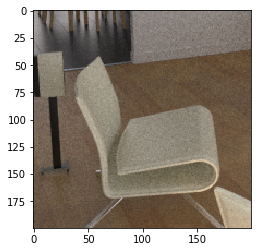

In [15]:
plt.imshow(zones_appart[0])

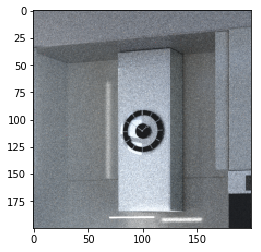

In [16]:
plt.imshow(zones_cuisine[0])

1.5583578798146742
0.4031962484250219


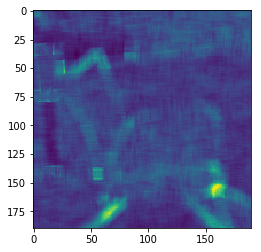

In [17]:
l_img = transform.get_LAB_L(zones_appart[0])
diff = diff_custom_filter(l_img, (11, 11), min)
print(np.mean(diff))
print(np.std(diff))
plt.imshow(diff)

In [ ]:
l_img = transform.get_LAB_L(zones_appart[-1])
diff = diff_custom_filter(l_img, (11, 11), min)
print(np.mean(diff))
print(np.std(diff))
plt.imshow(diff)

0.02973470988291801
0.027191091916047783
0.031610972587501264
0.025831133122543048
0.028261541600992254
0.025093711860205856
0.026282825279148853
0.02600373301574722
0.024353305763188646


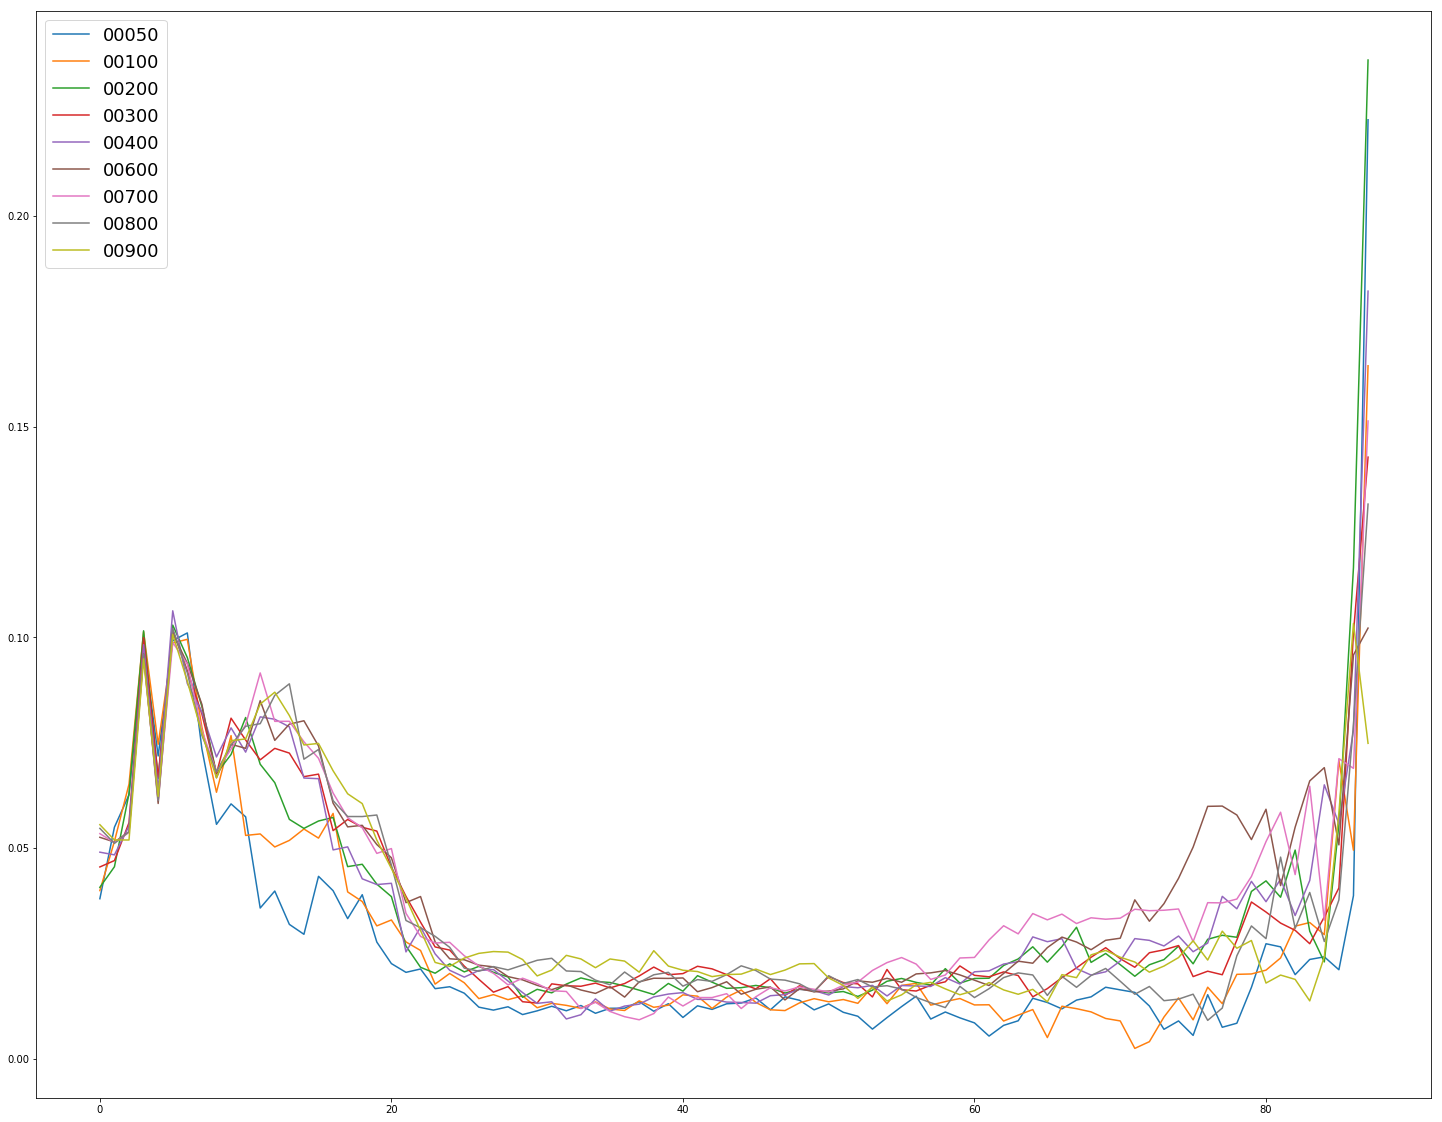

In [21]:
dict_infos = dict_appart

plt.figure(figsize=(25, 20))

for index, zone in enumerate(zones_appart):
    s_list = apply_filter_with_svd_divide(zone, (100, 100), max, (13, 13))
    
    s_norm = []
    
    for i in range(len(s_list[0])):
        norm = utils.normalize_arr(s_list[:,i])
        s_norm.append(np.std(norm))
    
    plt.plot(s_norm, label=dict_infos['indices'][index])
    print(np.std(s_norm))

plt.legend(fontsize=18)
plt.show()

In [160]:
%timeit diff_img = diff_custom_filter(l_img, kernel=(3, 3), func=max)
diff_img.shape

1.55 s ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(194, 194)

00050
00100
00200
00300
00400
00600
00700
00800
00900


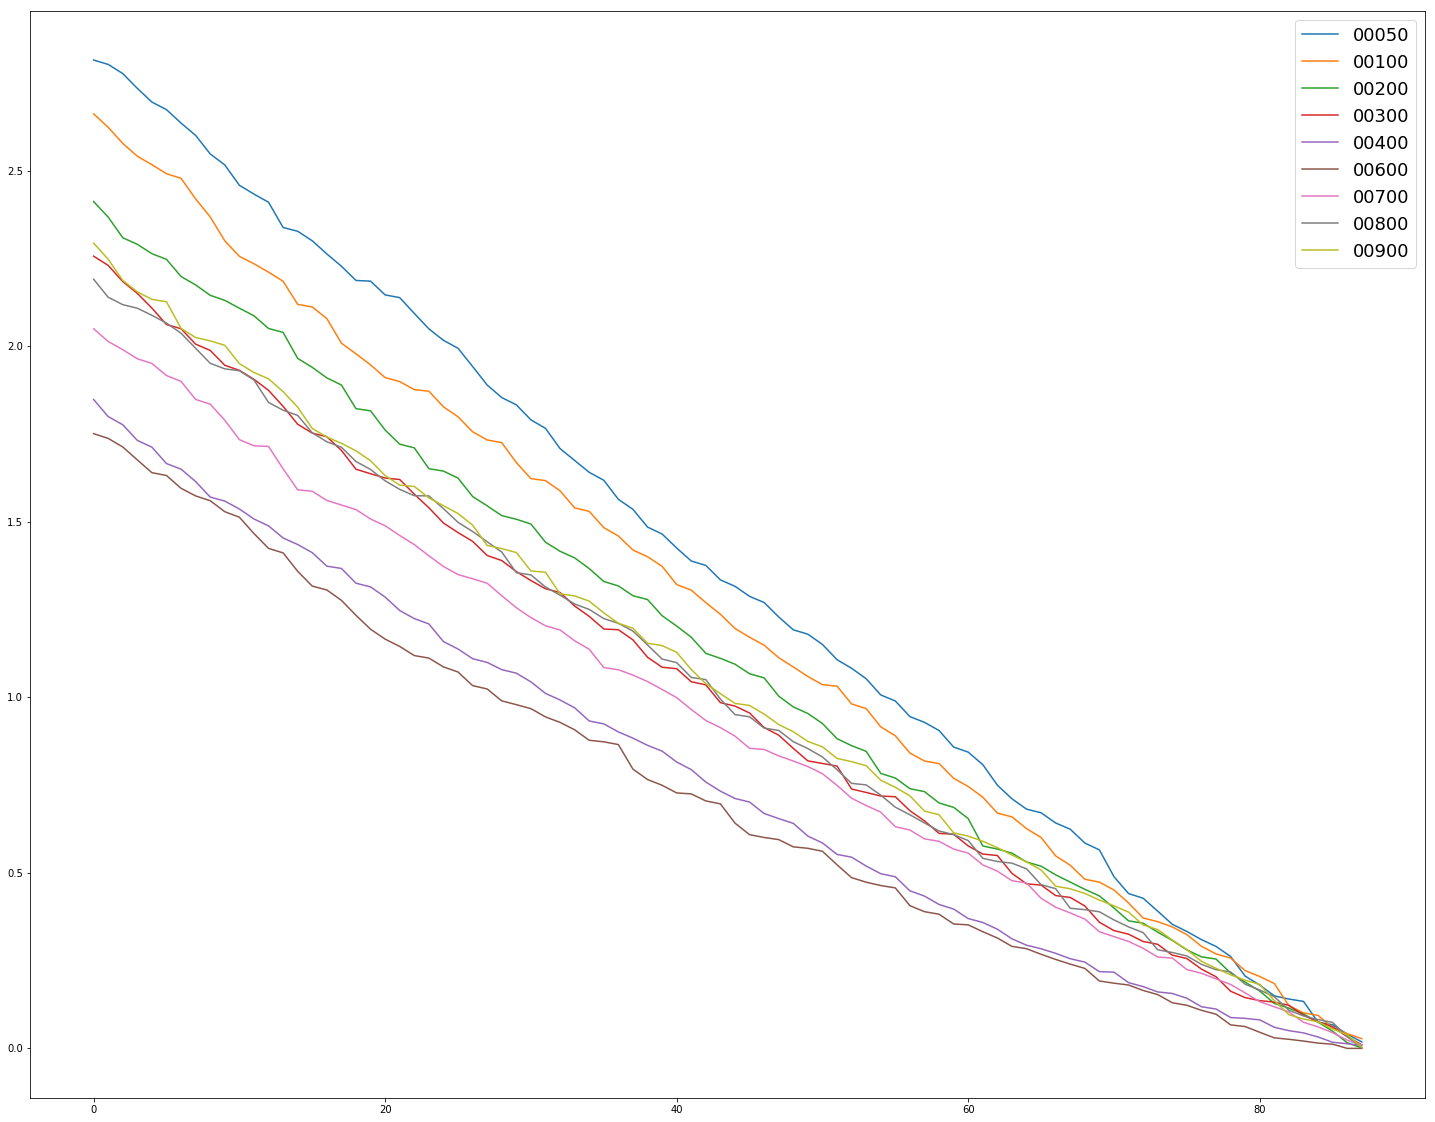

In [25]:
dict_infos = dict_appart
zones = zones_appart

plt.figure(figsize=(25, 20))

for index, zone in enumerate(zones):
    s = apply_filter_with_svd(zone, min, (13, 13))
    
    print(dict_infos['indices'][index])
    plt.plot(s[100:], label=dict_infos['indices'][index])

plt.legend(fontsize=18)
plt.show()